# Frozen Dessert Production Forecasting

## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

## Importing the data


In [2]:
df = pd.read_csv('./Frozen_Dessert_Production.csv')
df.columns = ['date', 'production']
df.set_index('date', inplace = True)
df

,production
date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


<Axes: xlabel='date'>

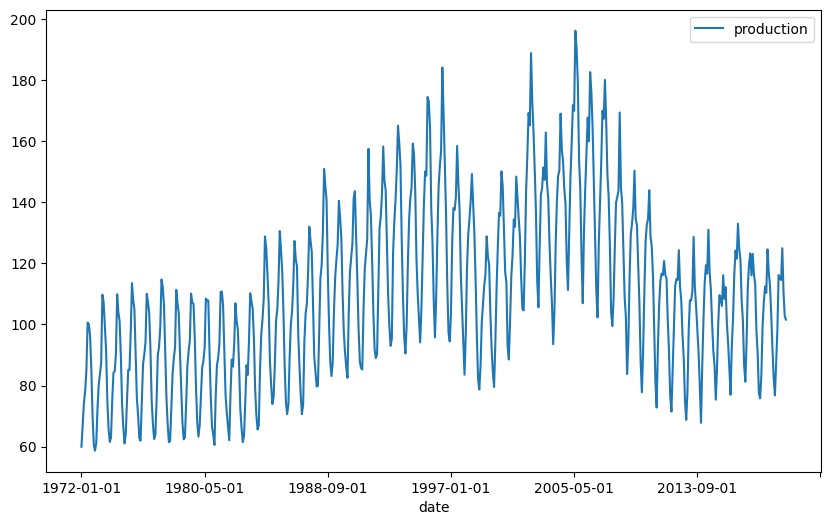

In [3]:
df.plot(figsize = (10, 6))

## Train Test Split

In [4]:
len(df)

573

In [5]:
test_length = 24
test_ind = len(df) - test_length
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [6]:
len(train)

549

In [7]:
len(test)

24

## Scaling the data

In [8]:
scaler = MinMaxScaler()

In [9]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(train)

## Time Series Generator

In [10]:
batch_size = 1
length = 18
n_features = 1

generator = TimeseriesGenerator(data = scaled_train,
                                targets = scaled_train,
                                length = length,
                                batch_size = batch_size)

validation_generator = TimeseriesGenerator(data = scaled_test,
                                           targets = scaled_test,
                                           length = length,
                                           batch_size = batch_size)

## Create the Model


In [11]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [13]:
model.fit(generator, validation_data = validation_generator, epochs = 20, callbacks = [early_stop])

Epoch 1/20
531/531 [==============================] - 19s 34ms/step - loss: 0.0290 - val_loss: 0.0199
Epoch 2/20
531/531 [==============================] - 9s 16ms/step - loss: 0.0149 - val_loss: 0.0073
Epoch 3/20
531/531 [==============================] - 12s 22ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 4/20
531/531 [==============================] - 10s 19ms/step - loss: 0.0045 - val_loss: 0.0062
Epoch 5/20
531/531 [==============================] - 10s 19ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 6/20
531/531 [==============================] - 12s 22ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 7/20
531/531 [==============================] - 11s 21ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 8/20
531/531 [==============================] - 9s 17ms/step - loss: 0.0031 - val_loss: 0.0035


In [14]:
loss = pd.DataFrame(model.history.history)

<Axes: >

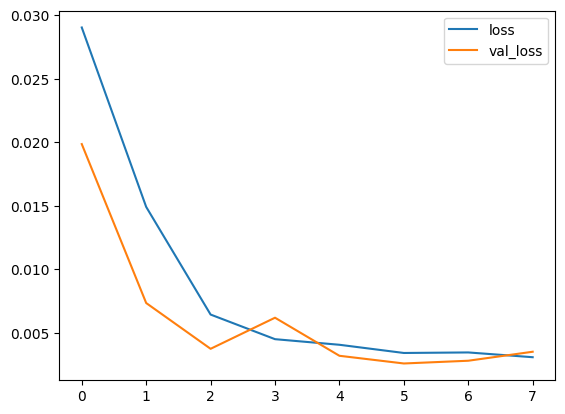

In [15]:
loss.plot()

## Evaluating on Test Data

In [16]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:,1:],[current_pred],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
test['predictions'] = true_predictions
test

1/1 [==============================] - 0s 23ms/step


<ipython-input-16-4b66b483525c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = true_predictions


,production,predictions
date,,
2017-10-01,90.4732,94.758734
2017-11-01,77.4378,89.573989
2017-12-01,75.8118,87.665210
2018-01-01,83.4343,99.932996
2018-02-01,99.4899,114.320152
2018-03-01,107.3152,126.380483
2018-04-01,112.4309,134.286021
2018-05-01,110.3544,138.584551
2018-06-01,124.5841,137.670948


<Axes: xlabel='date'>

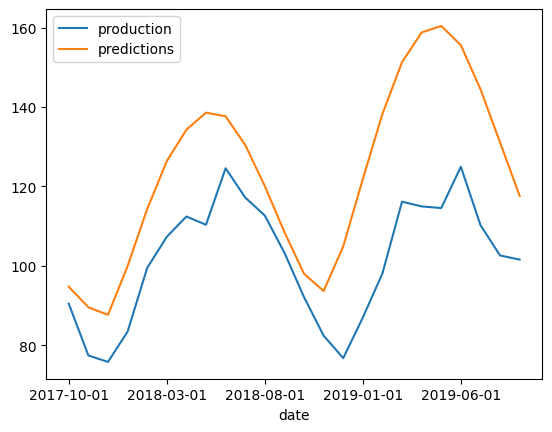

In [17]:
test.plot()

In [18]:
np.sqrt(mean_squared_error(test['production'],test['predictions']))

25.069152930804314